<a href="https://colab.research.google.com/github/rejunity/Artificial-Intelligence-Group/blob/master/Draw_sorted_by_neural_activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
The following notebook loads data from single behavioral session (one mouse) and one imaging experiment (just one plane) associated with that session to plot stimulus, licks and reward data and neural activity (one selected neuron). 

# Set up environment and import packages

We have built a package called `mindscope_utilities` which contains some useful convenience functions. The `allenSDK` is a dependency of this package and will be automatically installed when you install `mindscope_utilities` per the instrutions below.

We will first install `mindscope_utilities` into our colab environment by running the commands below. When this cell is complete, click on the `RESTART RUNTIME` button that appears at the end of the output. Note that running this cell will produce a long list of outputs and some error messages. Clicking `RESTART RUNTIME` at the end will resolve these issues. 

You can minimize the cell after you are done to hide the output. 

#### Install necessary packages

In [1]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

     |████████████████████████████████| 1.6MB 8.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 73 kB 1.4 MB/s 
     |████████████████████████████████| 1.7 MB 31.2 MB/s 
     |████████████████████████████████| 129 kB 54.8 MB/s 
     |████████████████████████████████| 2.9 MB 24.0 MB/s 
     |████████████████████████████████| 98 kB 8.1 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 4.3 MB 47.3 MB/s 
     |████████████████████████████████| 47.4 MB 32 kB/s 
     |████████████████████████████████| 149 kB 55.0 MB/s 
     |████████████████████████████████| 130 kB 45.7 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 3.4 MB 44.6 MB/s 
     |████████████████████████████████| 3.4 MB 58.3 MB/s 
     |████████████████████████████████| 668 kB 48.2 MB/s 
     |███████████████████████

#### Next we will import packages we need later in the notebook

In [6]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

# Load the session and experiment summary tables

We download the data cache:

- `ophys_session_table` contains data describing imaging sessions - one session can contain more than one imaging experiment (more than one plane), and not all behavioral session are accompanied by imaging. contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple *ophys experiment ids*. Each ophys session id will also have a unique *behavior session id*
- `behavior_session_table` contains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have *ophys session ids* were training sessions
- `ophys_experiment_table` contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique *experiment ids*. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the *ophys_container_id* column that can be found in both ophys_session_table and ophys_experiment_table

In [7]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

Then we can access the session and experiment tables directly.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane. 

In [8]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()
behavior_session_table = cache.get_behavior_session_table()

We can then view the contents of the session table. Note that this contains a lot of useful metadata about each session. One of the columns, `ophys_experiment_id` provides a list of the experiments (aka imaging planes) that are associated with each session.

# EXTRACT AND AVERAGE ACTIVITY OF ALL THE CELLS IN THE SESSION


### Make a dictionary of experiments in one session

In [9]:
def session_experiments(ophys_session_id):
  experiments = {}
  ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
  for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)
  return experiments

### Make a neural data dataset for one session

In [10]:
def session_neural_data(this_session_experiments):
  neural_data = []
  for ophys_experiment_id in tqdm(this_session_experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = this_session_experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
  # concatate the list of dataframes into a single dataframe
  neural_data = pd.concat(neural_data)
  
  return neural_data

### Make a session dictionary including a list of experiments and a dataframe with neural data

In [11]:
def make_session_dictionary_entry(ophys_session_id):
  this_session_experiments = session_experiments(ophys_session_id) #creates a dictionary of experiments in the session (experiment_id as a key)
  this_session_neural_data = session_neural_data(this_session_experiments)
  return [this_session_experiments, this_session_neural_data]

In [12]:
ophys_session_ids = [993727065, 954981981, 992232718, 977726123, 1010159622, 1000580083, 982431228]
session_dictionary = {}
for ophys_session_id in ophys_session_ids:
  session_dictionary[ophys_session_id] = make_session_dictionary_entry(ophys_session_id)



100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


### Extract data for one cell and align it with event times

In [16]:
def align_cell_with_event(ophys_session_id, ophys_experiment_id, cell_specimen_id, window_width = 3, session_dictionary = session_dictionary):
  #the function requires neural data for all the experiments in the session and a dictionary with experiments ids

  #identify experiment & corresponding neural data
  this_experiment = session_dictionary[ophys_session_id][0][ophys_experiment_id]
  neural_data = session_dictionary[ophys_session_id][1]

  # extract hits
  etr_hit = mindscope_utilities.event_triggered_response(
    data = neural_data.query('ophys_experiment_id == @ophys_experiment_id and cell_specimen_id == @cell_specimen_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = this_experiment.trials.query('hit')['change_time'],
    t_before=window_width,
    t_after=window_width,
    output_sampling_rate = 50,
  )
  # add hit indicator
  etr_hit['hit_miss'] = 'hit'

  # extract misses
  etr_miss = mindscope_utilities.event_triggered_response(
    data = neural_data.query('ophys_experiment_id == @ophys_experiment_id and cell_specimen_id == @cell_specimen_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = this_experiment.trials.query('miss')['change_time'],
    t_before=window_width,
    t_after=window_width,
    output_sampling_rate = 50,
  )
  # add miss indicator
  etr_miss['hit_miss'] = 'miss'

  #concatenate
  etr = pd.concat([etr_hit, etr_miss])

  #add session and cell specimen id, metadata
  etr['ophys_session_id'] = ophys_session_id
  etr['ophys_experiment_id'] = ophys_experiment_id  
  etr['cell_specimen_id'] = cell_specimen_id
  etr['cell_roi_id'] = this_experiment.dff_traces.loc[cell_specimen_id]['cell_roi_id']
  etr['cre_line'] = this_experiment.metadata['cre_line']
  etr['imaging_depth'] = this_experiment.metadata['imaging_depth']
  etr['mouse_id'] = this_experiment.metadata['mouse_id']
  etr['sex'] = this_experiment.metadata['sex']

  return etr

### Get cells from one session

In [14]:
def get_cells_from_session(ophys_session_id, session_dictionary = session_dictionary):
  ophys_experiment_ids = list(session_dictionary[ophys_session_id][0].keys())

  aligned_cells = []
  for ophys_experiment_id in ophys_experiment_ids:
    cells_specimen_ids = session_dictionary[ophys_session_id][0][ophys_experiment_id].dff_traces.index
    for cell_specimen_id in cells_specimen_ids:
      print('Session:', ophys_session_id, 'Experiment:', ophys_experiment_id, 'Cell:', cell_specimen_id)
      this_cell = align_cell_with_event(ophys_session_id, ophys_experiment_id, cell_specimen_id)
      aligned_cells.append(this_cell)
  
  aligned_cells = pd.concat(aligned_cells)

  return aligned_cells

In [15]:
my_cells = []
for ophys_session_id in ophys_session_ids:
  this_cells = get_cells_from_session(ophys_session_id)
  my_cells.append(this_cells)
  print(type(my_cells))
  #print(len(this_cells))
  #print(this_cells.keys())

my_cells = pd.concat(my_cells)

Session: 993727065 Experiment: 993862620 Cell: 1086496500
Session: 993727065 Experiment: 993862620 Cell: 1086496689
Session: 993727065 Experiment: 993862620 Cell: 1086497129
Session: 993727065 Experiment: 993862620 Cell: 1086497550
Session: 993727065 Experiment: 993862620 Cell: 1086500812
Session: 993727065 Experiment: 993862620 Cell: 1086497908
Session: 993727065 Experiment: 993862620 Cell: 1086498071
Session: 993727065 Experiment: 993862620 Cell: 1086498205
Session: 993727065 Experiment: 993862620 Cell: 1086498334
Session: 993727065 Experiment: 993862620 Cell: 1086498461
Session: 993727065 Experiment: 993862620 Cell: 1086498820
Session: 993727065 Experiment: 993862620 Cell: 1086498977
Session: 993727065 Experiment: 993862620 Cell: 1086499259
Session: 993727065 Experiment: 993862620 Cell: 1086499316
Session: 993727065 Experiment: 993862620 Cell: 1086499479
Session: 993727065 Experiment: 993862620 Cell: 1086499910
Session: 993727065 Experiment: 993862620 Cell: 1086500121
Session: 99372

In [27]:
print(len(my_cells))
my_cells.head()

5420107


,time,dff,event_number,event_time,hit_miss,ophys_session_id,ophys_experiment_id,cell_specimen_id,cell_roi_id,cre_line,imaging_depth,mouse_id,sex
0,-3.00,-0.020865,0,389.91903,hit,993727065,993862620,1086496500,1080706889,Sst-IRES-Cre,275,476970,M
1,-2.98,-0.042798,0,389.91903,hit,993727065,993862620,1086496500,1080706889,Sst-IRES-Cre,275,476970,M
2,-2.96,-0.095776,0,389.91903,hit,993727065,993862620,1086496500,1080706889,Sst-IRES-Cre,275,476970,M
3,-2.94,-0.106680,0,389.91903,hit,993727065,993862620,1086496500,1080706889,Sst-IRES-Cre,275,476970,M
4,-2.92,-0.099691,0,389.91903,hit,993727065,993862620,1086496500,1080706889,Sst-IRES-Cre,275,476970,M


In [178]:
dff_by_cell_over_time_hit  = my_cells.loc[my_cells['hit_miss'] == 'hit' ].groupby(['cell_specimen_id', 'time'], as_index=False).mean().pivot(index='cell_specimen_id', columns='time', values='dff')
print(dff_by_cell_over_time_hit.shape)
dff_by_cell_over_time_hit.head()

(78, 301)


time,-3.00,-2.98,-2.96,-2.94,-2.92,-2.90,-2.88,-2.86,-2.84,-2.82,-2.80,-2.78,-2.76,-2.74,-2.72,-2.70,-2.68,-2.66,-2.64,-2.62,-2.60,-2.58,-2.56,-2.54,-2.52,-2.50,-2.48,-2.46,-2.44,-2.42,-2.40,-2.38,-2.36,-2.34,-2.32,-2.30,-2.28,-2.26,-2.24,-2.22,-2.20,-2.18,-2.16,-2.14,-2.12,-2.10,-2.08,-2.06,-2.04,-2.02,-2.00,-1.98,-1.96,-1.94,-1.92,-1.90,-1.88,-1.86,-1.84,-1.82,-1.80,-1.78,-1.76,-1.74,-1.72,-1.70,-1.68,-1.66,-1.64,-1.62,-1.60,-1.58,-1.56,-1.54,-1.52,-1.50,-1.48,-1.46,-1.44,-1.42,-1.40,-1.38,-1.36,-1.34,-1.32,-1.30,-1.28,-1.26,-1.24,-1.22,-1.20,-1.18,-1.16,-1.14,-1.12,-1.10,-1.08,-1.06,-1.04,-1.02,-1.00,-0.98,-0.96,-0.94,-0.92,-0.90,-0.88,-0.86,-0.84,-0.82,-0.80,-0.78,-0.76,-0.74,-0.72,-0.70,-0.68,-0.66,-0.64,-0.62,-0.60,-0.58,-0.56,-0.54,-0.52,-0.50,-0.48,-0.46,-0.44,-0.42,-0.40,-0.38,-0.36,-0.34,-0.32,-0.30,-0.28,-0.26,-0.24,-0.22,-0.20,-0.18,-0.16,-0.14,-0.12,-0.10,-0.08,-0.06,-0.04,-0.02,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.20,0.22,0.24,0.26,0.28,0.30,0.32,0.34,0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.50,0.52,0.54,0.56,0.58,0.60,0.62,0.64,0.66,0.68,0.70,0.72,0.74,0.76,0.78,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00,1.02,1.04,1.06,1.08,1.10,1.12,1.14,1.16,1.18,1.20,1.22,1.24,1.26,1.28,1.30,1.32,1.34,1.36,1.38,1.40,1.42,1.44,1.46,1.48,1.50,1.52,1.54,1.56,1.58,1.60,1.62,1.64,1.66,1.68,1.70,1.72,1.74,1.76,1.78,1.80,1.82,1.84,1.86,1.88,1.90,1.92,1.94,1.96,1.98,2.00,2.02,2.04,2.06,2.08,2.10,2.12,2.14,2.16,2.18,2.20,2.22,2.24,2.26,2.28,2.30,2.32,2.34,2.36,2.38,2.40,2.42,2.44,2.46,2.48,2.50,2.52,2.54,2.56,2.58,2.60,2.62,2.64,2.66,2.68,2.70,2.72,2.74,2.76,2.78,2.80,2.82,2.84,2.86,2.88,2.90,2.92,2.94,2.96,2.98,3.00
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1086490391,-0.017337,-0.016043,-0.013589,-0.006435,0.002500,0.005920,0.007469,0.012999,0.017562,0.017547,0.013714,0.012212,0.014334,0.014766,0.014219,0.009248,0.005305,0.004492,0.002734,0.000702,-0.002384,-0.004412,-0.002139,-0.000001,-0.002380,-0.003606,-0.000900,-0.001989,-0.003092,-0.003556,-0.006731,-0.009614,-0.007323,-0.005853,-0.008516,-0.011992,-0.011688,-0.008831,-0.008968,-0.007091,0.001470,0.002960,0.006712,0.018562,0.024449,0.020952,0.015565,0.013300,0.012778,0.012808,0.008801,0.007438,0.009877,0.010409,0.006713,0.004831,0.005822,0.004873,0.001776,-0.002906,-0.005641,-0.006321,-0.006103,-0.006581,-0.005198,-0.007915,-0.009297,-0.006494,-0.005421,-0.005848,-0.003641,-0.007016,-0.012158,-0.007538,-0.000562,-0.003372,-0.006009,-0.006377,-0.002605,0.003215,0.008292,0.012577,0.011445,0.007336,0.008482,0.012134,0.014246,0.011525,0.009008,0.007064,0.004318,0.007970,0.010522,0.001707,-0.001058,0.000026,0.000887,-0.000017,-0.003446,-0.003463,-0.004555,-0.006892,-0.011840,-0.015064,-0.009587,-0.005300,-0.004681,-0.011524,-0.010658,-0.004268,-0.007084,-0.014160,-0.015015,-0.011617,-0.009992,-0.012527,-0.009502,-0.001230,0.006205,0.007007,0.003924,0.003131,0.006050,0.011221,0.007769,0.004516,0.006911,0.006359,0.002120,-0.002174,-0.008243,-0.005982,-0.000730,0.001471,-0.005152,-0.008617,-0.010953,-0.014518,-0.016428,-0.015500,-0.012344,-0.012391,-0.013743,-0.020087,-0.022914,-0.021349,-0.020102,-0.018298,-0.017405,-0.016897,-0.019333,-0.021844,-0.020811,-0.016609,-0.013756,-0.007251,0.001933,0.002145,0.002613,0.008709,0.017830,0.021985,0.026973,0.029311,0.030793,0.033775,0.034923,0.031988,0.020249,0.015098,0.010317,0.007648,0.009134,0.003553,0.001345,0.004968,0.003937,-0.002213,-0.006446,-0.006174,-0.009831,-0.012150,-0.014302,-0.013423,-0.011349,-0.011411,-0.010757,-0.011315,-0.010342,-0.011289,-0.008962,-0.001436,0.007206,0.023981,0.033722,0.034589,0.040426,0.049544,0.060544,0.058704,0.053082,0.057924,0.055182,0.048074,0.042446,0.038976,0.033579,0.024988,0.020799,0.022586,0.018629,0.008

In [24]:
dff_by_cell_over_time_miss = my_cells.loc[my_cells['hit_miss'] == 'miss'].groupby(['cell_specimen_id', 'time'], as_index=False).mean().pivot(index='cell_specimen_id', columns='time', values='dff')
print(dff_by_cell_over_time_miss.shape)
dff_by_cell_over_time_miss.head()

(78, 301)


time,-3.00,-2.98,-2.96,-2.94,-2.92,-2.90,-2.88,-2.86,-2.84,-2.82,-2.80,-2.78,-2.76,-2.74,-2.72,-2.70,-2.68,-2.66,-2.64,-2.62,-2.60,-2.58,-2.56,-2.54,-2.52,-2.50,-2.48,-2.46,-2.44,-2.42,-2.40,-2.38,-2.36,-2.34,-2.32,-2.30,-2.28,-2.26,-2.24,-2.22,-2.20,-2.18,-2.16,-2.14,-2.12,-2.10,-2.08,-2.06,-2.04,-2.02,-2.00,-1.98,-1.96,-1.94,-1.92,-1.90,-1.88,-1.86,-1.84,-1.82,-1.80,-1.78,-1.76,-1.74,-1.72,-1.70,-1.68,-1.66,-1.64,-1.62,-1.60,-1.58,-1.56,-1.54,-1.52,-1.50,-1.48,-1.46,-1.44,-1.42,-1.40,-1.38,-1.36,-1.34,-1.32,-1.30,-1.28,-1.26,-1.24,-1.22,-1.20,-1.18,-1.16,-1.14,-1.12,-1.10,-1.08,-1.06,-1.04,-1.02,-1.00,-0.98,-0.96,-0.94,-0.92,-0.90,-0.88,-0.86,-0.84,-0.82,-0.80,-0.78,-0.76,-0.74,-0.72,-0.70,-0.68,-0.66,-0.64,-0.62,-0.60,-0.58,-0.56,-0.54,-0.52,-0.50,-0.48,-0.46,-0.44,-0.42,-0.40,-0.38,-0.36,-0.34,-0.32,-0.30,-0.28,-0.26,-0.24,-0.22,-0.20,-0.18,-0.16,-0.14,-0.12,-0.10,-0.08,-0.06,-0.04,-0.02,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.20,0.22,0.24,0.26,0.28,0.30,0.32,0.34,0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.50,0.52,0.54,0.56,0.58,0.60,0.62,0.64,0.66,0.68,0.70,0.72,0.74,0.76,0.78,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00,1.02,1.04,1.06,1.08,1.10,1.12,1.14,1.16,1.18,1.20,1.22,1.24,1.26,1.28,1.30,1.32,1.34,1.36,1.38,1.40,1.42,1.44,1.46,1.48,1.50,1.52,1.54,1.56,1.58,1.60,1.62,1.64,1.66,1.68,1.70,1.72,1.74,1.76,1.78,1.80,1.82,1.84,1.86,1.88,1.90,1.92,1.94,1.96,1.98,2.00,2.02,2.04,2.06,2.08,2.10,2.12,2.14,2.16,2.18,2.20,2.22,2.24,2.26,2.28,2.30,2.32,2.34,2.36,2.38,2.40,2.42,2.44,2.46,2.48,2.50,2.52,2.54,2.56,2.58,2.60,2.62,2.64,2.66,2.68,2.70,2.72,2.74,2.76,2.78,2.80,2.82,2.84,2.86,2.88,2.90,2.92,2.94,2.96,2.98,3.00
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1086490391,-0.006113,-0.005463,-0.006029,-0.007449,-0.007552,0.000007,0.007520,0.008142,0.005147,0.004080,0.004882,0.012817,0.018010,0.012819,0.005422,0.009384,0.019470,0.015143,0.004701,-0.002182,-0.002813,0.000844,0.005323,0.003891,-0.002493,-0.004476,-0.013146,-0.014974,-0.011039,-0.016261,-0.013082,-0.005483,-0.006555,-0.003818,-0.000377,-0.000321,-0.003659,-0.010910,-0.009287,-0.005007,-0.006620,-0.005206,0.000545,0.000940,0.001690,0.006050,0.004670,0.006686,0.008043,0.003203,0.002894,0.005537,0.002116,-0.000495,-0.000971,-0.006793,-0.004963,-0.002050,-0.006233,-0.011219,-0.002147,0.012380,0.007083,-0.008648,-0.007681,-0.000594,-0.002218,-0.007438,-0.016888,-0.017303,-0.005246,-0.002127,-0.009619,-0.008773,-0.011621,-0.010829,-0.008480,-0.008422,-0.009415,-0.002286,0.013413,0.016806,0.011474,0.007477,0.003177,0.002587,0.004769,0.008548,0.007287,0.007735,0.005086,0.000252,-0.000509,-0.006049,-0.005091,0.007312,0.003994,-0.000678,0.002255,0.001622,-0.000338,-0.005228,-0.006157,0.001293,-0.004609,-0.007842,-0.008557,-0.010536,-0.006309,-0.003605,-0.007298,-0.001428,0.001362,-0.002928,-0.007353,-0.002976,0.011914,0.015935,0.013598,0.015589,0.018883,0.013885,0.016955,0.026846,0.031149,0.025715,0.012526,0.013251,0.021010,0.012660,0.003391,0.007462,0.010074,0.014871,0.011287,0.002725,0.001086,0.000278,0.002937,-0.000730,-0.009588,-0.011340,-0.008101,-0.014362,-0.013209,-0.002299,-0.001353,-0.000355,-0.007519,-0.012648,-0.006277,-0.000186,-0.003811,-0.008481,-0.004770,0.002968,0.017060,0.028928,0.028283,0.020203,0.010839,0.013682,0.018138,0.015742,0.008597,0.007579,0.010245,0.008114,0.006243,0.010904,0.008952,0.006471,-0.002673,-0.008915,-0.004891,-0.010376,-0.012492,-0.005167,-0.008422,-0.010391,-0.010533,-0.002382,-0.008631,-0.011577,-0.009369,-0.001557,0.000033,-0.003852,0.001302,-0.002894,-0.012097,-0.009345,0.005800,0.008217,0.004106,0.012638,0.021310,0.031197,0.028007,0.019077,0.024114,0.026663,0.020549,0.017738,0.017264,0.009385,0.004500,0.005730,-0.001037,-0.001395,0.000610,-0.00696

In [79]:
my_cells['cell_roi_id'].unique()

array([1080706889, 1080706896, 1080706914, 1080706925, 1080706940,
       1080706948, 1080706952, 1080706955, 1080706961, 1080706969,
       1080706975, 1080706977, 1080706983, 1080706985, 1080706987,
       1080707001, 1080707019, 1080707021, 1080763069, 1080763072,
       1080763075, 1080763080, 1080763089, 1080763095, 1080763100,
       1080763107, 1080763120, 1080763124, 1080763129, 1080763140,
       1080763146, 1080763149, 1080763154, 1080763162, 1080763166,
       1080671165, 1080671168, 1080671174, 1080671176, 1080671182,
       1080671187, 1080671191, 1080671198, 1080671200, 1080671202,
       1080671205, 1080671206, 1080671209, 1080671217, 1080671218,
       1080671220, 1080671221, 1080740893, 1080740895, 1080740898,
       1080740900, 1080740903, 1080740906, 1080740912, 1080740917,
       1080709867, 1080709869, 1080709871, 1080709872, 1080709873,
       1080709875, 1080709882, 1080691111, 1080691112, 1080691113,
       1080691114, 1080691117, 1080731043, 1080731073, 1080731

Neurons that react strongest after 0


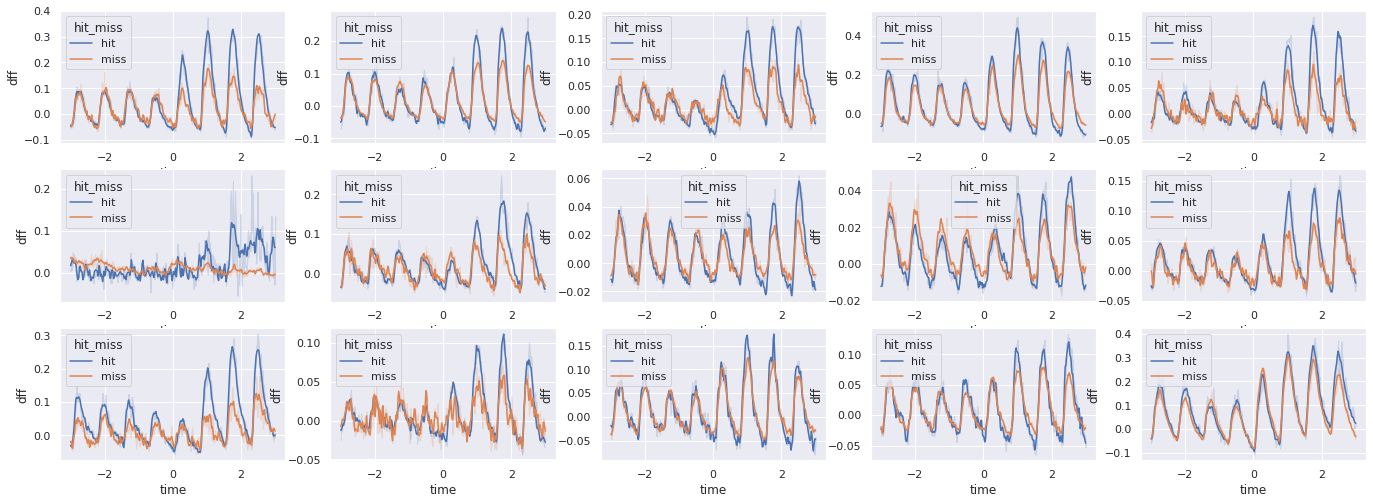

Neurons that go silent after 0 or have no correlations


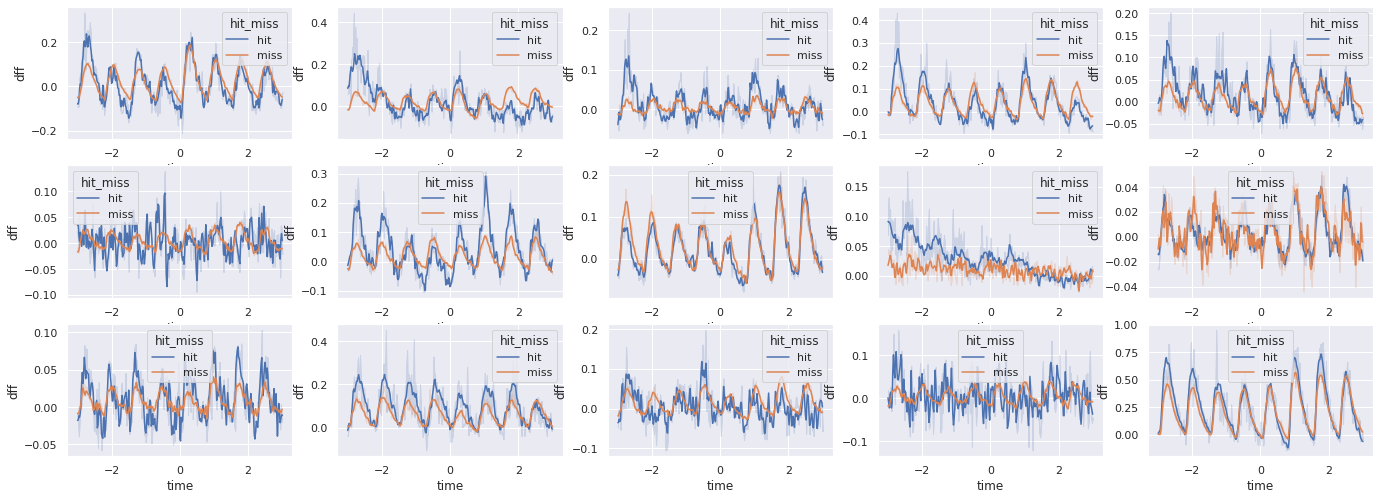

Sorted neurons Int64Index([1080671209, 1080706977, 1080671174, 1080706896, 1080671218,
            1080763129, 1080671187, 1080731097, 1080731043, 1080671206,
            1080671176, 1080671217, 1080706955, 1080706987, 1080706925,
            1080731080, 1080763095, 1080671200, 1080671165, 1080740917,
            1080691112, 1080691117, 1080706961, 1080709872, 1080706975,
            1080706985, 1080731090, 1080707001, 1080671198, 1080671205,
            1080707019, 1080706914, 1080671182, 1080671168, 1080709871,
            1080707021, 1080709867, 1080691114, 1080731073, 1080706889,
            1080731105, 1080671202, 1080763162, 1080706948, 1080740900,
            1080763149, 1080706983, 1080671220, 1080671191, 1080691113,
            1080763072, 1080763166, 1080706969, 1080709882, 1080691111,
            1080763140, 1080709875, 1080763120, 1080709869, 1080763100,
            1080740903, 1080763075, 1080706940, 1080763107, 1080740912,
            1080740895, 1080763124, 1080763080, 1

In [176]:
my_cells_before_cue = my_cells[my_cells['time'] < 0.0]
my_cells_after_cue = my_cells[my_cells['time'] > 0.0]
my_misses0 = my_cells_before_cue.loc[my_cells_before_cue['hit_miss'] == 'miss']
my_hits0 = my_cells_before_cue.loc[my_cells_before_cue['hit_miss'] == 'hit']
my_misses1 = my_cells_after_cue.loc[my_cells_after_cue['hit_miss'] == 'miss' ]
my_hits1 = my_cells_after_cue.loc[my_cells_after_cue['hit_miss'] == 'hit']

mean_misses0 = my_misses0.groupby(['cell_roi_id']).mean()**2
mean_misses1 = my_misses1.groupby(['cell_roi_id']).mean()**2
mean_hits0 = my_hits0.groupby(['cell_roi_id']).mean()**2
mean_hits1 = my_hits1.groupby(['cell_roi_id']).mean()**2

sd_before_cue = (my_misses0.groupby(['cell_roi_id', 'time']).mean() - my_hits0.groupby(['cell_roi_id', 'time']).mean()).groupby(['cell_roi_id']).var()
sd_after_cue = (my_misses1.groupby(['cell_roi_id', 'time']).mean() - my_hits1.groupby(['cell_roi_id', 'time']).mean()).groupby(['cell_roi_id']).var()

cells_sorted_by_difference_in_hits_vs_misses = (sd_after_cue / sd_before_cue).sort_values(['dff'], ascending=False)

print('Neurons that react strongest after 0')
fig, axs = plt.subplots(ncols=5, nrows=3)
fig.set_size_inches(11.7*2, 8.27)
#sns.set(rc={'figure.figsize':('1024px','768px')})
for iy in range(3):
  for ix in range(5):
    sns.lineplot(
    data=my_cells.loc[my_cells['cell_roi_id'] == cells_sorted_by_difference_in_hits_vs_misses.index[iy*5+ix]],
    x='time',
    y='dff',
    hue='hit_miss',
    n_boot=1,
    ax=axs[iy][ix])

plt.show()
print('Neurons that go silent after 0 or have no correlations')

fig, axs = plt.subplots(ncols=5, nrows=3)
fig.set_size_inches(11.7*2, 8.27)
#sns.set(rc={'figure.figsize':('1024px','768px')})
for iy in range(3):
  for ix in range(5):
    sns.lineplot(
    data=my_cells.loc[my_cells['cell_roi_id'] == cells_sorted_by_difference_in_hits_vs_misses.index[len(cells_sorted_by_difference_in_hits_vs_misses.index) - iy*5 - ix - 1]],
    x='time',
    y='dff',
    hue='hit_miss',
    n_boot=1,
    ax=axs[iy][ix])
plt.show()  

print('Sorted neurons', cells_sorted_by_difference_in_hits_vs_misses.index)

In [24]:
for ophys_session_id in ophys_session_ids:
  this_cells = get_cells_from_session(ophys_session_id)
  print('hit_miss', this_cells['hit_miss'].unique())
  print('event_number', this_cells['event_number'].unique())
  print('imaging_depth', this_cells['imaging_depth'].unique())
  print('mouse_id', this_cells['mouse_id'].unique())
  print('sex', this_cells['sex'].unique())

  print('cell_s', this_cells['cell_specimen_id'].unique())
  print('cell_r', this_cells['cell_roi_id'].unique())

  #this_cells.pivot(index='cell_roi_id', columns='time', values='dff').head()

Session: 993727065 Experiment: 993862620 Cell: 1086496500
Session: 993727065 Experiment: 993862620 Cell: 1086496689
Session: 993727065 Experiment: 993862620 Cell: 1086497129
Session: 993727065 Experiment: 993862620 Cell: 1086497550
Session: 993727065 Experiment: 993862620 Cell: 1086500812
Session: 993727065 Experiment: 993862620 Cell: 1086497908
Session: 993727065 Experiment: 993862620 Cell: 1086498071
Session: 993727065 Experiment: 993862620 Cell: 1086498205
Session: 993727065 Experiment: 993862620 Cell: 1086498334
Session: 993727065 Experiment: 993862620 Cell: 1086498461
Session: 993727065 Experiment: 993862620 Cell: 1086498820
Session: 993727065 Experiment: 993862620 Cell: 1086498977
Session: 993727065 Experiment: 993862620 Cell: 1086499259
Session: 993727065 Experiment: 993862620 Cell: 1086499316
Session: 993727065 Experiment: 993862620 Cell: 1086499479
Session: 993727065 Experiment: 993862620 Cell: 1086499910
Session: 993727065 Experiment: 993862620 Cell: 1086500121
Session: 99372

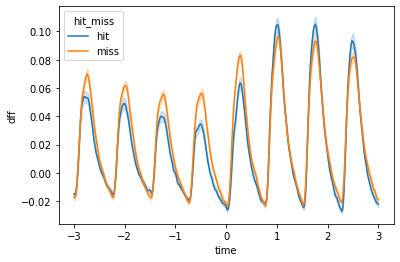

In [ ]:
sns.lineplot(
    data=my_cells,
    x='time',
    y='dff',
    hue='hit_miss',
    n_boot=500
)